<a href="https://colab.research.google.com/github/ccastano1997/Volatility-Based-Trading-Signal-Generation-using-LSTM-Networks/blob/main/Volatility_Based_Trading_Signal_Generation_using_LSTM_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance pandas numpy scikit-learn tensorflow pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=582c1b2b3661ea62b3495d763f9905fe4ab436c795351633117fa76d34e903b1
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
pip install --upgrade pandas pandas_ta numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 2

In [ ]:
# Uninstall current versions to ensure a clean slate
!pip uninstall -y numpy pandas pandas_ta

# Install specific, Colab-friendly versions
!pip install numpy==1.26.4 pandas==2.2.2 pandas_ta

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: pandas_ta 0.3.14b0
Uninstalling pandas_ta-0.3.14b0:
  Successfully uninstalled pandas_ta-0.3.14b0
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached pandas_ta-0.3.14b0-py3-none-any.whl
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.

In [11]:
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

## =================================================================
## PART 1: DATA PREPARATION
## =================================================================

# Use an explicit end date to ensure the full range is downloaded
spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')

# Flatten columns
spy_df.columns = spy_df.columns.get_level_values(0)

# Add technical indicators
spy_df.ta.rsi(append=True)
spy_df.ta.macd(append=True)
spy_df.ta.bbands(append=True)

# Add the target variable
spy_df['Target'] = (spy_df['Close'].shift(-1) > spy_df['Close']).astype(int)

# Remove all incomplete rows at once
spy_df.dropna(inplace=True)

# Scale the Features
features = spy_df.columns.drop('Target')
target = 'Target'
scaler = MinMaxScaler()
spy_df[features] = scaler.fit_transform(spy_df[features])

print("✅ Data preparation complete.")
print(f"New DataFrame shape: {spy_df.shape}")


## =================================================================
## PART 2: BUILD AND TRAIN THE LSTM MODEL
## =================================================================

sequence_length = 60
X = []
y = []

features_np = spy_df[features].to_numpy()
target_np = spy_df[target].to_numpy()

for i in range(len(spy_df) - sequence_length):
    X.append(features_np[i:i + sequence_length])
    y.append(target_np[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split into Training and Test Sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the Model
model = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=50)),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the Model
print("\nStarting model training... This will take a few minutes. 🚀")
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

print("\n✅ Model training complete.")

/tmp/ipython-input-11-4136306888.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Data preparation complete.
New DataFrame shape: (3617, 15)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 100)        │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,501 (337.89 KB)

 Trainable params: 86,501 (337.89 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training... This will take a few minutes. 🚀
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.5540 - loss: 0.6879 - val_accuracy: 0.5860 - val_loss: 0.6910
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5097 - loss: 0.6940 - val_accuracy: 0.5860 - val_loss: 0.6789
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5627 - loss: 0.6872 - val_accuracy: 0.5860 - val_loss: 0.6834
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5420 - loss: 0.6910 - val_accuracy: 0.5860 - val_loss: 0.6797
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5635 - loss: 0.6841 - val_accuracy: 0.5860 - val_loss: 0.6797
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.5542 - loss: 0.6877 - val_accuracy: 0.5860 - val_loss: 0.6782
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5591 - loss: 0.6864 - val_accuracy: 0.5860 - val_loss: 0.6813
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 85m

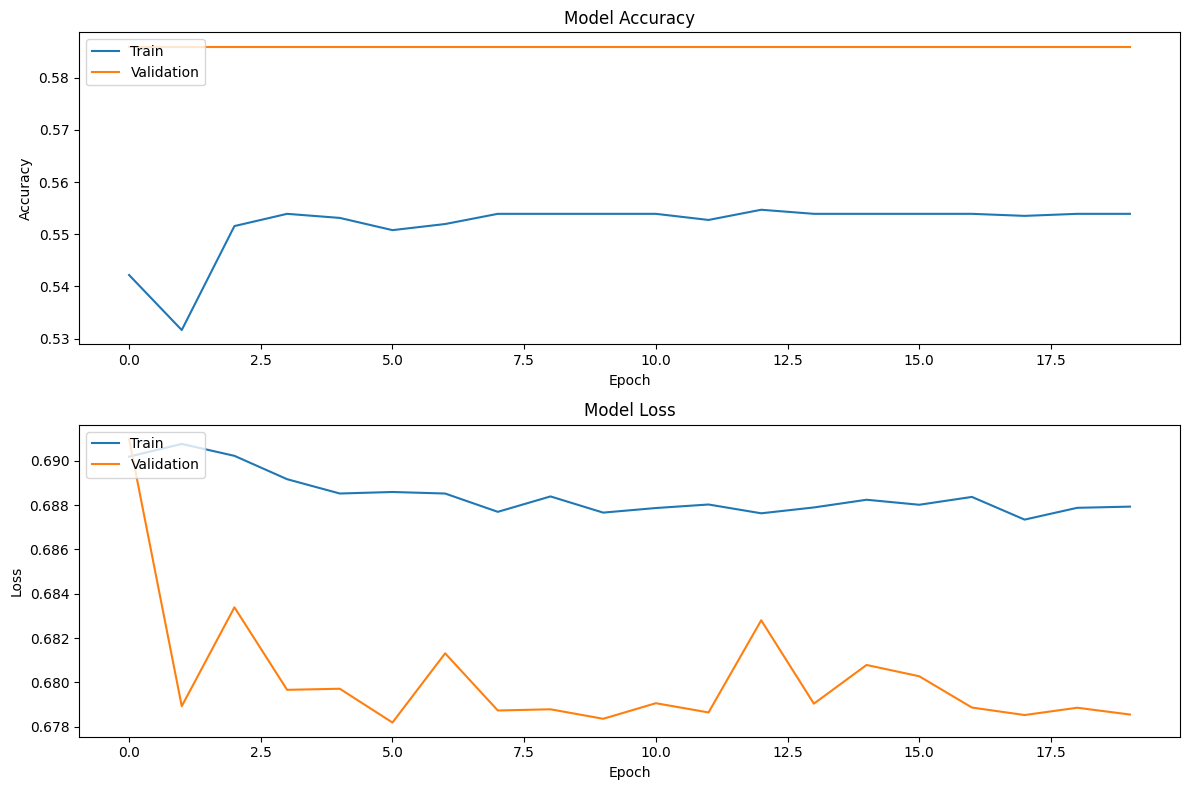

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


/tmp/ipython-input-12-537889165.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_test_data['Prediction'] = (predictions > 0.5).astype(int)
/tmp/ipython-input-12-537889165.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_test_data['Market_Return'] = original_test_data['Close'].pct_change()
/tmp/ipython-input-12-537889165.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

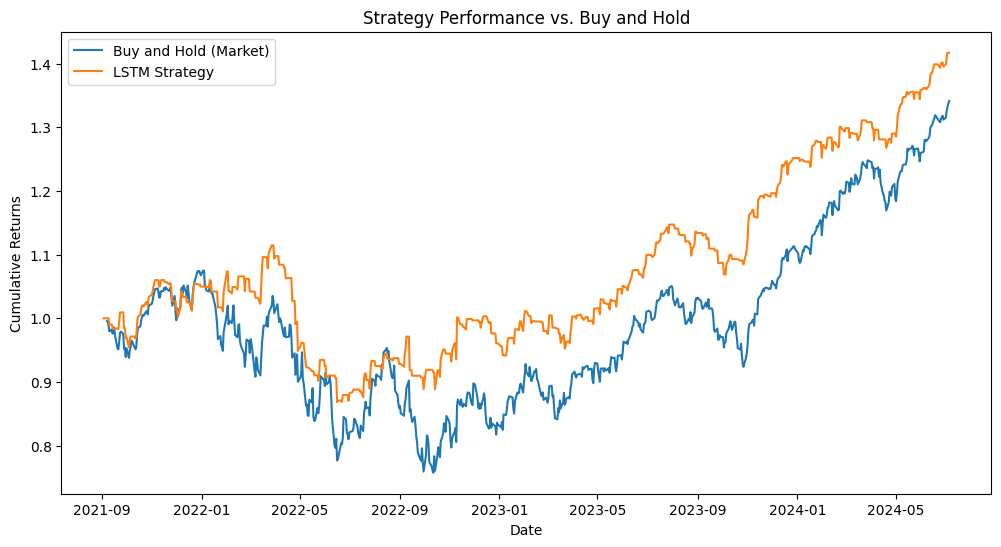

In [12]:
import matplotlib.pyplot as plt

# --- 1. Visualizing Training History ---


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# --- 2. Backtest on the Test Set (Most Important) ---
# This simulates how the model would have performed on unseen data.

# Getting the original 'Close' prices from the test period
original_test_data = spy_df.iloc[split + sequence_length:]

# Getting the model's predictions on the test set
predictions = model.predict(X_test)

# Adding the predictions and the actual 'Target' to the test data DataFrame
original_test_data['Prediction'] = (predictions > 0.5).astype(int)

# Calculating daily market returns
original_test_data['Market_Return'] = original_test_data['Close'].pct_change()

# Calculating strategy returns (Will only get the market return if the prediction was correct)
original_test_data['Strategy_Return'] = np.where(original_test_data['Prediction'] == original_test_data['Target'], original_test_data['Market_Return'], 0)

# Calculating cumulative returns for both strategies
original_test_data['Cumulative_Market_Return'] = (1 + original_test_data['Market_Return']).cumprod()
original_test_data['Cumulative_Strategy_Return'] = (1 + original_test_data['Strategy_Return']).cumprod()

# Plotting the equity curve
plt.figure(figsize=(12, 6))
plt.plot(original_test_data['Cumulative_Market_Return'], label='Buy and Hold (Market)')
plt.plot(original_test_data['Cumulative_Strategy_Return'], label='LSTM Strategy')
plt.title('Strategy Performance vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

In [14]:
pip freeze > requirements.txt

# **🧪 V2 Model: Advanced Features & Architecture**

In [15]:
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

## =================================================================
## PART 1: ADVANCED DATA PREPARATION & FEATURE ENGINEERING
## =================================================================

# --- 1a. Download SPY and VIX Data ---
# We now download the VIX (volatility index) as a new feature
spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')
vix_df = yf.download('^VIX', start='2010-01-01', end='2024-07-08')

# Flatten columns
spy_df.columns = spy_df.columns.get_level_values(0)
vix_df.columns = vix_df.columns.get_level_values(0)

# --- 1b. Advanced Feature Engineering ---
# Add our base technical indicators
spy_df.ta.rsi(append=True)
spy_df.ta.macd(append=True)
spy_df.ta.bbands(append=True)
# Add new, more advanced indicators
spy_df.ta.atr(append=True) # Average True Range (Volatility)
spy_df.ta.obv(append=True) # On-Balance Volume (Momentum)

# Add the VIX Close as a new feature column
spy_df['VIX_Close'] = vix_df['Close']

# Add an interaction feature: Distance from 50-day moving average
spy_df['SMA_50'] = spy_df['Close'].rolling(window=50).mean()
spy_df['Dist_From_SMA'] = spy_df['Close'] - spy_df['SMA_50']


# --- 1c. Advanced Target Definition ---
# Predict if the next day's move is significant ( > recent volatility)
spy_df['Volatility'] = spy_df['Close'].pct_change().rolling(window=5).std()
spy_df['Target'] = (spy_df['Close'].shift(-1) / spy_df['Close'] - 1) > spy_df['Volatility'].shift(1)
spy_df['Target'] = spy_df['Target'].astype(int)


# --- 1d. Final Processing ---
# Remove all incomplete rows *after* all features are calculated
spy_df.dropna(inplace=True)

# Scale the Features (all columns except the target)
features = spy_df.columns.drop('Target')
target = 'Target'
scaler = MinMaxScaler()
spy_df[features] = scaler.fit_transform(spy_df[features])

print("✅ V2 Data preparation complete.")
print(f"New DataFrame shape: {spy_df.shape}")


## =================================================================
## PART 2: V2 - DEEPER MODEL ARCHITECTURE
## =================================================================

sequence_length = 60
X = []
y = []

features_np = spy_df[features].to_numpy()
target_np = spy_df[target].to_numpy()

for i in range(len(spy_df) - sequence_length):
    X.append(features_np[i:i + sequence_length])
    y.append(target_np[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Train-Test Split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build the Deeper Model ---
model_v2 = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3), # Increased dropout for a larger model
    Bidirectional(LSTM(units=100, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(units=50)), # Third LSTM layer
    Dropout(0.3),
    Dense(units=1, activation='sigmoid')
])

model_v2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_v2.summary()

# --- Train the V2 Model ---
print("\nStarting V2 model training... 🚀")
history_v2 = model_v2.fit(
    X_train,
    y_train,
    epochs=30, # Increased epochs as the model is more complex
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

print("\n✅ V2 Model training complete.")

/tmp/ipython-input-15-2716152384.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-15-2716152384.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix_df = yf.download('^VIX', start='2010-01-01', end='2024-07-08')
[*********************100%***********************]  1 of 1 completed


✅ V2 Data preparation complete.
New DataFrame shape: (3601, 21)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 60, 200)        │        96,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 60, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 100)            │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,101 (1.67 MB)

 Trainable params: 438,101 (1.67 MB)

 Non-trainable params: 0 (0.00 B)


Starting V2 model training... 🚀
Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 349ms/step - accuracy: 0.7735 - loss: 0.5153 - val_accuracy: 0.7782 - val_loss: 0.5391
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 325ms/step - accuracy: 0.8283 - loss: 0.4745 - val_accuracy: 0.7782 - val_loss: 0.5299
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.8038 - loss: 0.5014 - val_accuracy: 0.7782 - val_loss: 0.5332
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 323ms/step - accuracy: 0.8187 - loss: 0.4792 - val_accuracy: 0.7782 - val_loss: 0.5310
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 319ms/step - accuracy: 0.8236 - loss: 0.4746 - val_accuracy: 0.7782 - val_loss: 0.5290
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 328ms/step - accuracy: 0.8172 - loss: 0.4798 - val_accuracy: 0.7782 - val_loss: 0.5310
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 323ms/step - accuracy: 0.8108 - loss: 0.4896 - val_accuracy: 0.7782 - val_loss: 0.5302
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy:

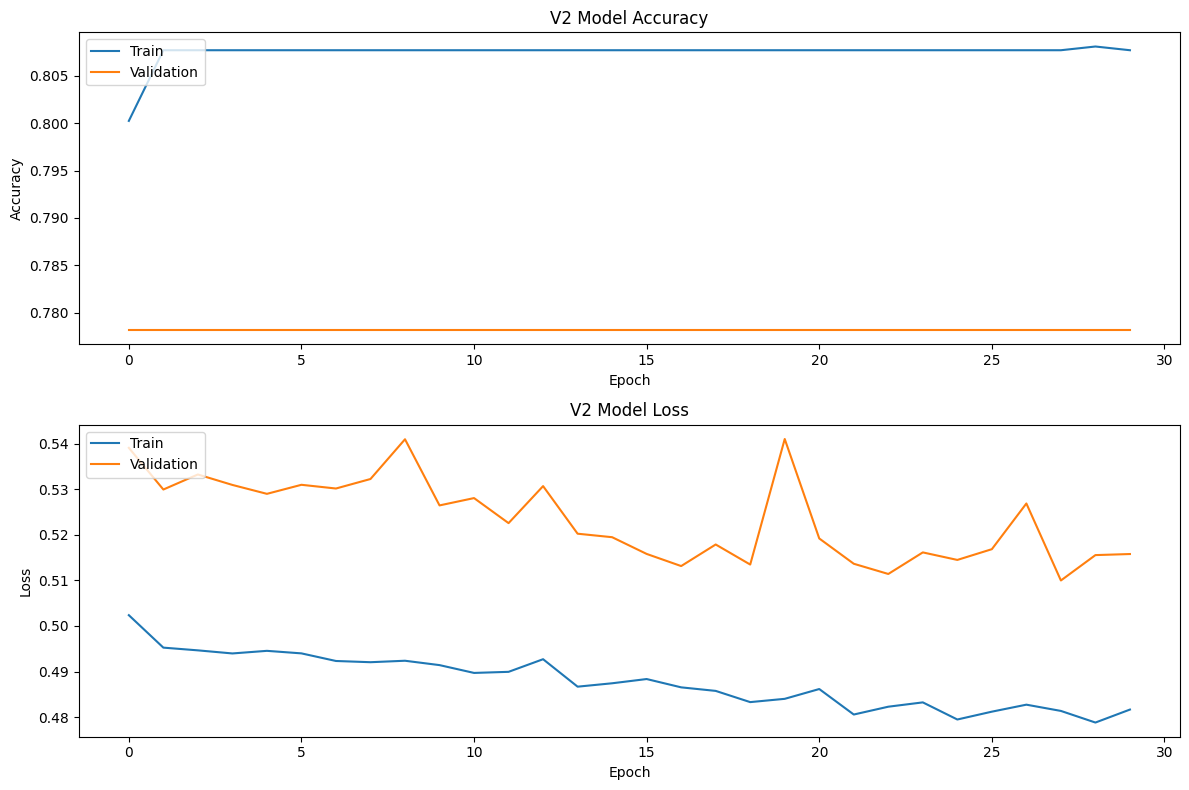

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step


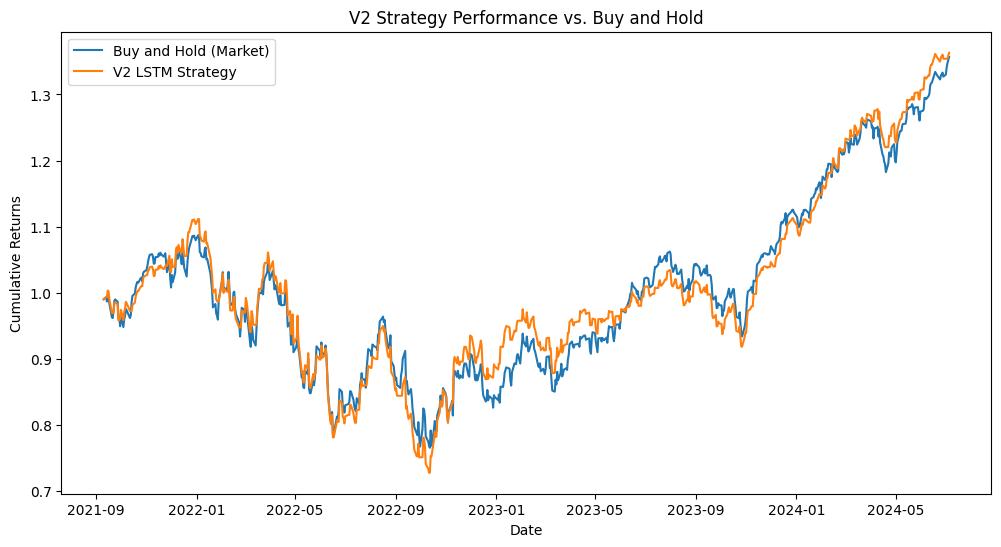

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Visualize V2 Training History ---
# This uses the 'history_v2' object from the new model's training.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot training & validation accuracy values
ax1.plot(history_v2.history['accuracy'])
ax1.plot(history_v2.history['val_accuracy'])
ax1.set_title('V2 Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history_v2.history['loss'])
ax2.plot(history_v2.history['val_loss'])
ax2.set_title('V2 Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# --- 2. Backtest the V2 Strategy on the Test Set ---
# This simulates how the V2 model would have performed on unseen data.

# Get the original 'Close' prices from the test period
# Note: The iloc index needs to account for the rows we dropped
original_test_data_v2 = spy_df.iloc[split + sequence_length:]

# Get the V2 model's predictions
predictions_v2 = model_v2.predict(X_test)

# Add the predictions and the actual 'Target' to our test data DataFrame
# We need to be careful here as the DataFrame index might not align perfectly after creating sequences.
# It's safer to create new columns on a copied DataFrame.
backtest_df = original_test_data_v2.copy()
backtest_df['Prediction'] = (predictions_v2 > 0.5).astype(int)

# Calculate daily market returns
backtest_df['Market_Return'] = backtest_df['Close'].pct_change()

# Calculate strategy returns.
# If our model correctly predicted a significant move was coming (Prediction=1) AND the real target was also 1, we invest.
# Otherwise, we stay in cash (return = 0). This is a simple but effective test.
backtest_df['Strategy_Return'] = np.where(backtest_df['Prediction'] == backtest_df['Target'], backtest_df['Market_Return'], 0)

# Calculate cumulative returns for both strategies
backtest_df['Cumulative_Market_Return'] = (1 + backtest_df['Market_Return']).cumprod()
backtest_df['Cumulative_Strategy_Return'] = (1 + backtest_df['Strategy_Return']).cumprod()

# Plot the equity curve for the V2 model
plt.figure(figsize=(12, 6))
plt.plot(backtest_df['Cumulative_Market_Return'], label='Buy and Hold (Market)')
plt.plot(backtest_df['Cumulative_Strategy_Return'], label='V2 LSTM Strategy')
plt.title('V2 Strategy Performance vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()

# **🧪 V3 Model: Combatting Overfitting**

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# --- Build the V3 Model with Anti-Overfitting Techniques ---
model_v3 = Sequential([
    Bidirectional(LSTM(units=100, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))), # Added L2
    Dropout(0.4), # Increased Dropout
    Bidirectional(LSTM(units=100, return_sequences=True, kernel_regularizer=regularizers.l2(0.001))), # Added L2
    Dropout(0.4), # Increased Dropout
    Bidirectional(LSTM(units=50, kernel_regularizer=regularizers.l2(0.001))), # Added L2
    Dropout(0.4), # Increased Dropout
    Dense(units=1, activation='sigmoid')
])

model_v3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Defining the Early Stopping Callback ---
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True # Restore the weights from the best epoch
)

# --- Training the V3 Model ---
print("\nStarting V3 model training with early stopping... 🚀")
history_v3 = model_v3.fit(
    X_train,
    y_train,
    epochs=100, #Settting a high number of epochs; early stopping will find the best one
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping], # Adding the callback here
    verbose=1
)


Starting V3 model training with early stopping... 🚀
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.7867 - loss: 1.2393 - val_accuracy: 0.7782 - val_loss: 0.7781
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 330ms/step - accuracy: 0.8083 - loss: 0.6923 - val_accuracy: 0.7782 - val_loss: 0.6300
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 324ms/step - accuracy: 0.8050 - loss: 0.5872 - val_accuracy: 0.7782 - val_loss: 0.5889
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 329ms/step - accuracy: 0.7976 - loss: 0.5546 - val_accuracy: 0.7782 - val_loss: 0.5675
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.8066 - loss: 0.5232 - val_accuracy: 0.7782 - val_loss: 0.5511
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 0.8043 - loss: 0.5180 - val_accuracy: 0.7782 - val_loss: 0.5424
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.8155 - loss: 0.5007 - val_accuracy: 0.7782 - val_loss: 0.5395
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━

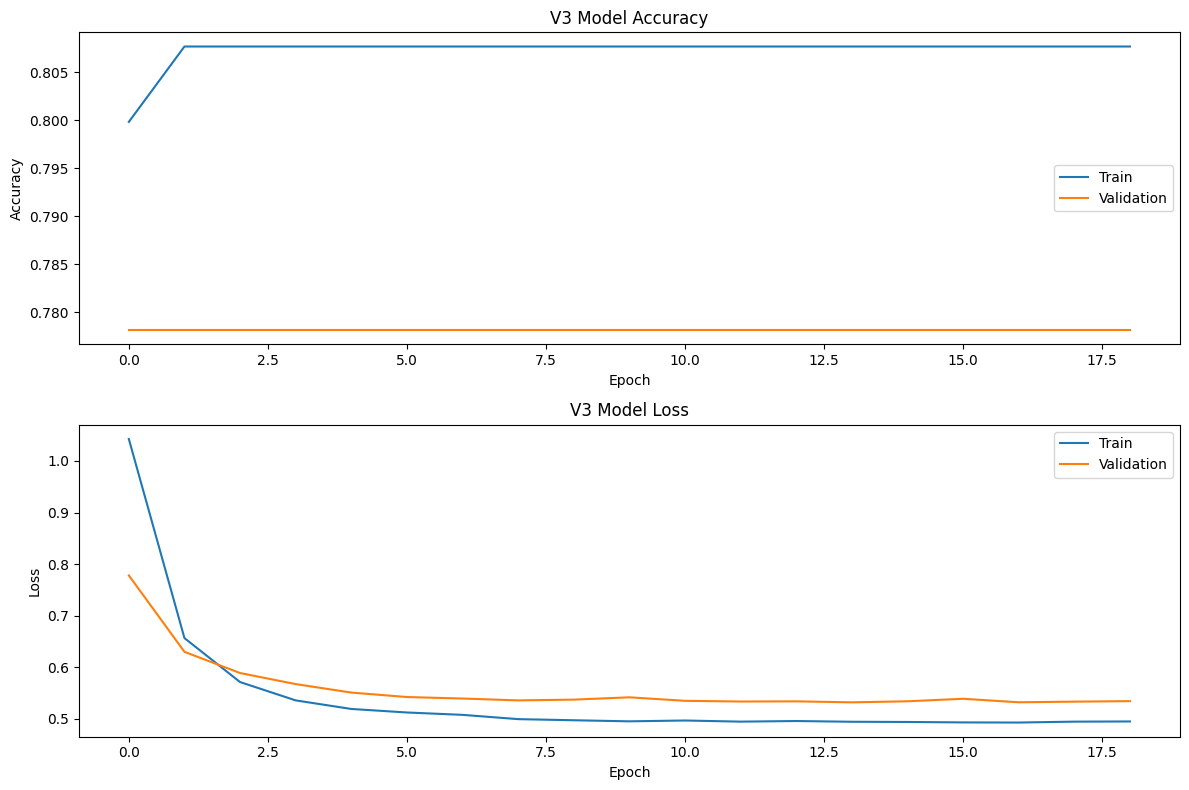

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step


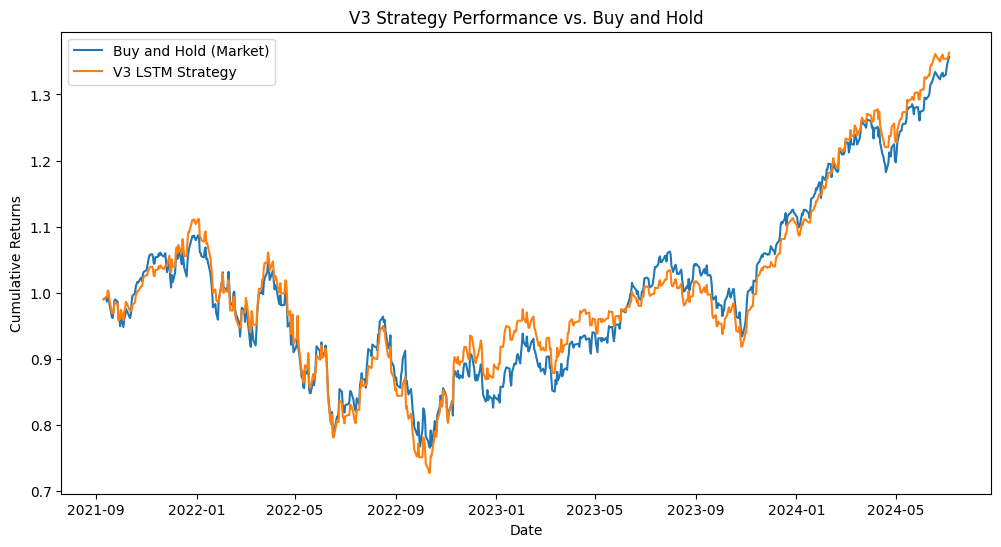

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Visualize V3 Training History ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot V3 accuracy
ax1.plot(history_v3.history['accuracy'], label='Train')
ax1.plot(history_v3.history['val_accuracy'], label='Validation')
ax1.set_title('V3 Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()

# Plot V3 loss
ax2.plot(history_v3.history['loss'], label='Train')
ax2.plot(history_v3.history['val_loss'], label='Validation')
ax2.set_title('V3 Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()


# --- 2. Backtest the V3 Strategy ---
# Create a fresh copy of the test data for this backtest
backtest_df_v3 = original_test_data_v2.copy()

# Get V3 model's predictions
predictions_v3 = model_v3.predict(X_test)
backtest_df_v3['Prediction'] = (predictions_v3 > 0.5).astype(int)

# Calculate returns
backtest_df_v3['Market_Return'] = backtest_df_v3['Close'].pct_change()
backtest_df_v3['Strategy_Return'] = np.where(
    backtest_df_v3['Prediction'] == backtest_df_v3['Target'],
    backtest_df_v3['Market_Return'],
    0
)

# Calculate cumulative returns
backtest_df_v3['Cumulative_Market_Return'] = (1 + backtest_df_v3['Market_Return']).cumprod()
backtest_df_v3['Cumulative_Strategy_Return'] = (1 + backtest_df_v3['Strategy_Return']).cumprod()

# Plot the V3 equity curve
plt.figure(figsize=(12, 6))
plt.plot(backtest_df_v3['Cumulative_Market_Return'], label='Buy and Hold (Market)')
plt.plot(backtest_df_v3['Cumulative_Strategy_Return'], label='V3 LSTM Strategy')
plt.title('V3 Strategy Performance vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()